<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/HW/rahatalberuni/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6: Deep Learning with CNNs for Star Morphology Analysis

In this final assignment, you will use the same FITS files you explored previously, which contain astronomical images of stars in a specific region of the sky. This time, you will train a convolutional neural network (CNN) to classify stars based on morphological features directly from cropped image patches extracted from the FITS image.

The CNN will be used to:
- Distinguish between point sources (stars), extended sources (galaxies or nebula fragments), and image artifacts (like hot pixels or diffraction spikes).
- Optionally predict star brightness class (dim, moderate, bright) or other physically relevant labels.

### Learning Objectives:

By the end of this assignment, you should be able to:
- Understand how convolutional neural networks extract spatial features from astronomical images.
- Build and train a CNN using TensorFlow.
- Evaluate and visualize model performance on scientific image data.

In [5]:
# Install required libraries
!pip install astropy scikit-learn tensorflow matplotlib numpy photutils auto-stretch astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 48.2 MB/s eta 0:00:00


In [6]:
! pip install ipytest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.3 MB/s eta 0:00:00


In [7]:
import ipytest
import pytest
ipytest.autoconfig()

### For pytest to recognize a test function it should start with test_

In [8]:
def my_sum(a,b, c):
  return a+b+c

In [9]:
%%ipytest
# this defines unit test

def test_my_sum():
  """ this tests are my_sum function for arithematic corrrectness """
  assert my_sum(1, 2, 0) == 3, "Should be 3"
  assert my_sum(0, 0, 0) == 0, "Should be 0"
  assert my_sum(-1, 2, -1) == 0, "Should be 0"

.                                                                                            [100%]
1 passed in 0.02s


In [10]:
ipytest.run()

.                                                                                            [100%]
1 passed in 0.02s


<ExitCode.OK: 0>

## Task 1: Data Preparation (8 points)
- Use the same FITS file from Homework 5
- Use astropy to determine the wcs coordinates of the image
- Generate a pandas list os the 10 brightest objects in the image

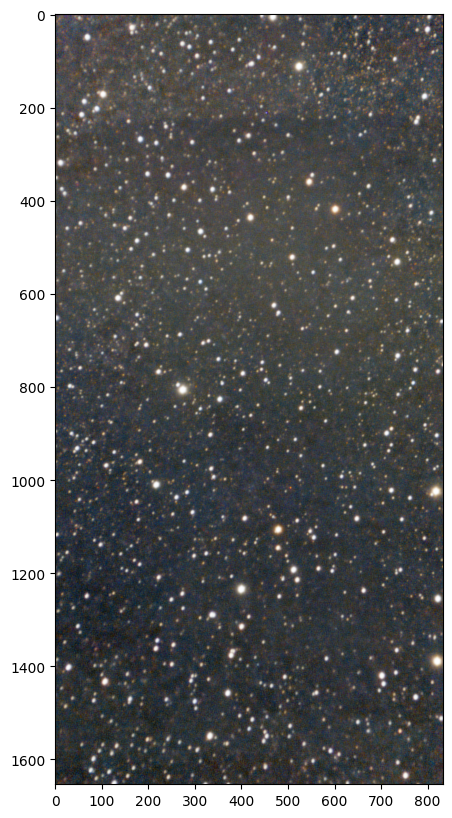

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO

fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/7.fits"
response = requests.get(fits_url)
response.raise_for_status()
fits_data = fits.open(BytesIO(response.content))

hdul = fits.open(BytesIO(response.content))
image_data = np.transpose( hdul[0].data, (1,2,0))
image_data = image_data[400:-400, 400:-400,:]
hdul.close()


fig = plt.figure(figsize=(10, 10))
plt.imshow(apply_stretch(image_data))


In [12]:
image_data.shape

(1654, 833, 3)

In [13]:
import pandas as pd
from astropy.wcs import WCS
from astropy.stats import mad_std
from photutils.detection import DAOStarFinder

bkg_sigma = mad_std(np.mean(image_data, axis=2))

daofind = DAOStarFinder(fwhm=3.0, threshold=10 * bkg_sigma, min_separation = 15)
sources = daofind(np.mean(image_data, axis=2))

catalog = sources.to_pandas().sort_values('flux', ascending=False).head(10)

catalog

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
251,252,273.377594,806.576316,0.425941,-0.282498,0.175253,25,55613.666667,821162.333333,-14.786073,-6.468629
336,337,817.388593,1024.839572,0.420552,-0.250291,0.176155,25,55965.666667,813973.000000,-14.776525,-6.504323
431,432,820.031304,1389.998945,0.399475,0.074820,0.457190,25,48525.333333,790821.666667,-14.745196,-6.139191
396,397,399.277225,1235.371203,0.422109,-0.241461,0.373443,25,39093.666667,603286.666667,-14.451309,-6.009395
32,33,523.293583,111.150661,0.441973,-0.388732,0.240654,25,34534.666667,526592.666667,-14.303687,-5.876555
357,358,478.538203,1106.984465,0.448770,-0.354340,0.138752,25,23294.333333,332198.000000,-13.803493,-5.579657
0,1,467.194208,4.129805,0.433856,-0.386213,0.269620,25,19743.333333,324071.333333,-13.776602,-5.141076
330,331,216.470980,1010.784583,0.448259,-0.454461,0.181686,25,21464.000000,323334.000000,-13.774128,-5.394404
117,118,600.953825,418.142595,0.443885,-0.480311,0.141247,25,21680.666667,311349.666667,-13.733121,-5.500801
405,406,821.476137,1255.543217,0.444161,-0.155379,0.294207,25,16888.000000,273436.333333,-13.592141,-4.988685


In [14]:
wcs = WCS(hdul[0].header, naxis=2)
print(wcs)
sky_coords = wcs.all_pix2world(catalog['xcentroid'], catalog['ycentroid'], 1)
catalog['ra'] = sky_coords[0]
catalog['dec'] = sky_coords[1]
catalog

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 2.44472434302991 84.9544534609015 
CRPIX : 816.5 1227.0 
PC1_1 PC1_2  : 0.987411461566597 0.158172708034338 
PC2_1 PC2_2  : -0.158317218701835 0.987388301663796 
CDELT : -0.00110925677600271 0.00110956680435752 
NAXIS : 1633  2454  3


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec
251,252,273.377594,806.576316,0.425941,-0.282498,0.175253,25,55613.666667,821162.333333,-14.786073,-6.468629,9.499685,84.548230
336,337,817.388593,1024.839572,0.420552,-0.250291,0.176155,25,55965.666667,813973.000000,-14.776525,-6.504323,2.820495,84.732704
431,432,820.031304,1389.998945,0.399475,0.074820,0.457190,25,48525.333333,790821.666667,-14.745196,-6.139191,2.062111,85.132302
396,397,399.277225,1235.371203,0.422109,-0.241461,0.373443,25,39093.666667,603286.666667,-14.451309,-6.009395,7.695167,85.016109
32,33,523.293583,111.150661,0.441973,-0.388732,0.240654,25,34534.666667,526592.666667,-14.303687,-5.876555,7.206569,83.762266
357,358,478.538203,1106.984465,0.448770,-0.354340,0.138752,25,23294.333333,332198.000000,-13.803493,-5.579657,6.822040,84.867443
0,1,467.194208,4.129805,0.433856,-0.386213,0.269620,25,19743.333333,324071.333333,-13.776602,-5.141076,7.848744,83.648280
330,331,216.470980,1010.784583,0.448259,-0.454461,0.181686,25,21464.000000,323334.000000,-13.774128,-5.394404,10.102630,84.776646
117,118,600.953825,418.142595,0.443885,-0.480311,0.141247,25,21680.666667,311349.666667,-13.733121,-5.500801,6.120479,84.094153
405,406,821.476137,1255.543217,0.444161,-0.155379,0.294207,25,16888.000000,273436.333333,-13.592141,-4.988685,2.325090,84.984840


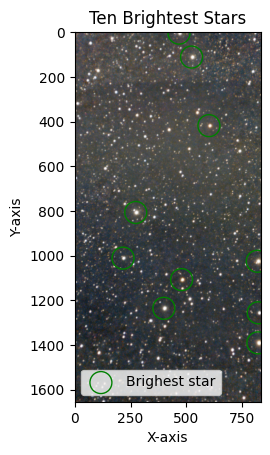

In [15]:
fig = plt.figure()
plt.imshow(apply_stretch(image_data))
plt.scatter(catalog['xcentroid'], catalog['ycentroid'], color='green', marker = 'o', facecolors='none', s=250, label='Brighest star')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.title('Ten Brightest Stars')
plt.show()


## Task 2: Determine the properties of the stars based on a catalog (8 points)
- use the SIMBAD catalog (available through astropy) to determine the following properties of the 10 brightest objects in you image:
    - Name of the object
    - Spectral class
    - object type
    - absolute magnitude (you might have to calculate it)
    - distance to earth

In [16]:
from astroquery.simbad import Simbad
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import tqdm

options = Simbad.list_votable_fields()
options[options["type"] == "bundle of basic columns"][["name", "description"]]

name,description
object,object
coordinates,all fields related with coordinates
dim,"major and minor axis, angle and inclination"
dimensions,all fields related to object dimensions
morphtype,all fields related to the morphological type
parallax,all fields related to parallaxes
propermotions,all fields related with the proper motions
sp,all fields related with the spectral type
velocity,all fields related with radial velocity and redshift


In [17]:
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm

# Configure Simbad
Simbad.ROW_LIMIT = 1
Simbad.reset_votable_fields()
Simbad.add_votable_fields("mesdistance", "V", "sp", "otype", "ids")

# Loop through catalog
for idx, row in tqdm(catalog.iterrows(), total=catalog.shape[0]):
    ra, dec = row['ra'], row['dec']
    coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
    print(coord)
    try:
        result = Simbad.query_region(coord, radius="10s")
        if result:
          catalog.at[idx, 'star_name'] = result[0]['main_id']
          catalog.at[idx, 'spectral_type'] = result[0]['sp_type']
          catalog.at[idx, 'object_type'] = result[0]['otype']
          catalog.at[idx, 'visual_mag'] = result[0]['V']

          dist = result[0]['mesdistance_distance']
          catalog.at[idx, 'simbad_distance_pc'] = float(dist) if dist is not None else None

    except Exception as e:
        print(f"Error querying Simbad for {idx}: {e}")


  0%|          | 0/10 [00:00<?, ?it/s]

<SkyCoord (ICRS): (ra, dec) in deg
    (9.49968536, 84.54822965)>


 20%|██        | 2/10 [00:00<00:02,  3.53it/s]

<SkyCoord (ICRS): (ra, dec) in deg
    (2.82049522, 84.73270427)>
<SkyCoord (ICRS): (ra, dec) in deg
    (2.06211097, 85.13230184)>


 40%|████      | 4/10 [00:00<00:01,  4.89it/s]

<SkyCoord (ICRS): (ra, dec) in deg
    (7.69516664, 85.01610886)>
Error querying Simbad for 396: 'mesdistance_distance'
<SkyCoord (ICRS): (ra, dec) in deg
    (7.20656884, 83.76226587)>


 60%|██████    | 6/10 [00:01<00:00,  5.56it/s]

<SkyCoord (ICRS): (ra, dec) in deg
    (6.82204002, 84.86744345)>
<SkyCoord (ICRS): (ra, dec) in deg
    (7.84874414, 83.64828001)>


 80%|████████  | 8/10 [00:01<00:00,  6.39it/s]

<SkyCoord (ICRS): (ra, dec) in deg
    (10.10263008, 84.77664618)>
<SkyCoord (ICRS): (ra, dec) in deg
    (6.1204793, 84.09415279)>


100%|██████████| 10/10 [00:02<00:00,  4.96it/s]

<SkyCoord (ICRS): (ra, dec) in deg
    (2.32508995, 84.98483964)>


## Task 3: Visualize and label (10 points)
Draw a 64x64 patch of each of the 10 brightest objects and generate a list to label each patch based on:

- Morphology
    - star
    - extended (nebula, galaxy, cluster, ...)
    - artifact (hot pixel, cosmic ray, ...)
    - if you do not have all types, artificially generate one example of each. Use a LLM to have specific shapes suggested. Document if it suggests useful shapes.
- Brightness class
- Spectral class

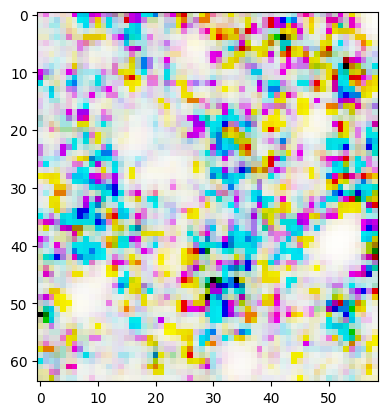

In [18]:
import matplotlib.pyplot as plt

def make_path(image, x, y, size=64):
  x_min = int(np.clip(x-size/2, 0, image.shape[0]))
  x_max = int(np.clip(x+size/2, 0, image.shape[0]))
  y_min = int(np.clip(y-size/2, 0, image.shape[1]))
  y_max = int(np.clip(y+size/2, 0, image.shape[1]))
  return image[x_min:x_max, y_min:y_max]

 # plt.imshow(apply_stretch(make_patch(red_image,catalog['xcentroid'][100],catalog['ycentroid'][100])),cmap='gray')
plt.imshow(apply_stretch(make_path(image_data, catalog['xcentroid'].iloc[0], catalog['ycentroid'].iloc[0]))) # changed make_patch to make_path

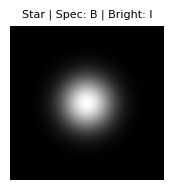

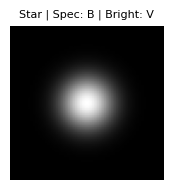

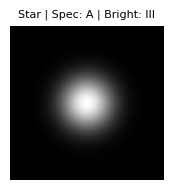

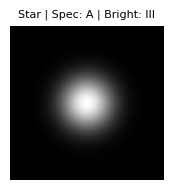

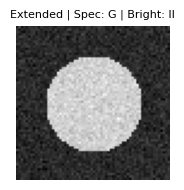

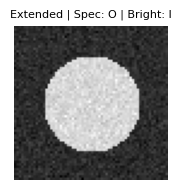

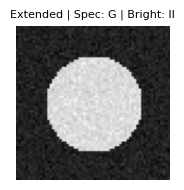

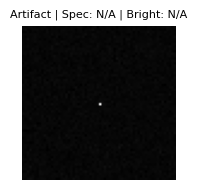

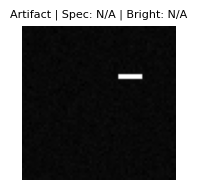

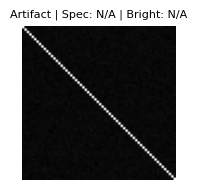

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#Patch Generators
def generate_star_patch():
    x = np.linspace(-3, 3, 64)
    y = np.linspace(-3, 3, 64)
    X, Y = np.meshgrid(x, y)
    patch = np.exp(-(X**2 + Y**2))  # Gaussian star
    return patch

def generate_extended_patch():
    patch = np.zeros((64, 64))
    rr, cc = np.ogrid[:64, :64]
    mask = (rr - 32)**2 + (cc - 32)**2 < 20**2
    patch[mask] = np.random.uniform(0.5, 1.0)
    patch += np.random.normal(0, 0.05, patch.shape)
    return patch

def generate_artifact_patch(shape="hot_pixel"):
    patch = np.random.normal(0, 0.01, (64, 64))
    if shape == "hot_pixel":
        patch[32, 32] = 1.0
    elif shape == "cosmic_ray":
        patch[20:22, 40:50] = 1.0
    elif shape == "diagonal_stripe":
        np.fill_diagonal(patch, 1.0)
    return patch

# --- Label Options ---
spectral_classes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
brightness_classes = ['I', 'II', 'III', 'IV', 'V']

# --- Generate and Label 10 Patches ---
patches = []
labels = []

for i in range(10):
    if i < 4:
        patch = generate_star_patch()
        morph = "star"
        spec = np.random.choice(spectral_classes)
        bright = np.random.choice(brightness_classes)
    elif i < 7:
        patch = generate_extended_patch()
        morph = "extended"
        spec = np.random.choice(spectral_classes)
        bright = np.random.choice(brightness_classes)
    else:
        shape = ["hot_pixel", "cosmic_ray", "diagonal_stripe"][i - 7]
        patch = generate_artifact_patch(shape)
        morph = "artifact"
        spec = None
        bright = None

    patches.append(patch)
    labels.append({
        "index": i,
        "morphology": morph,
        "spectral_class": spec,
        "brightness_class": bright
    })

# --- Display Patches with Labels ---
for i, (patch, label) in enumerate(zip(patches, labels)):
    plt.figure(figsize=(2,2))
    plt.imshow(patch, cmap='gray')
    title = f"{label['morphology'].capitalize()} | "
    title += f"Spec: {label['spectral_class'] or 'N/A'} | "
    title += f"Bright: {label['brightness_class'] or 'N/A'}"
    plt.title(title, fontsize=8)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


## Task 4: Build a CNN (8 points)
- Use TensorFlow/Keras to build a small CNN.
    - Recommended architecture:
    - Conv2D → ReLU → MaxPool
    - Conv2D → ReLU → MaxPool
    - Flatten → Dense → Softmax

You can adapt this depending on whether you are doing binary or multi-class classification.

In [23]:
import tensorflow.keras.models as models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

num_classes = 4

# Create a sequential model using models.Sequential()
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 output classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # use sparse_categorical_crossentropy if labels are integers
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,891 (3.14 MB)

 Trainable params: 821,891 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

## Task 5: Train the Model (10 points)

Now use the top 100 (you can also use more to generate better training data) objects with all information in your image to train your model on the parameters spectral class and absolute magnitude and distance if possible. If you do not have all types genererate 10 examples of each type missing.
Store the resulting pandas dataframe as `catalog.csv` in the same directory as you Jupyter notebook.

Split your dataset into training, validation, and test sets.
- Use categorical crossentropy loss and an appropriate optimizer (e.g., Adam).
- Plot training and validation accuracy/loss curves.

Hint: SIMBAD has a very detailed set of spectral types. Group them according to the main letter (O, B, A, F, G, K, M)

Ask a LLM what final plot you should generate that shows if the CNN works for classification. Generate that plot.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import numpy as np
def extral_spectral_class(s):
  """ simplify spectral class, e.g. M1 --> M """
  if s is np.nan:
    return s
    return s[0]

catalog['extra_spectral_class'] = catalog['spectral_type'].apply(extral_spectral_class)
catalog.head(100)

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec,star_name,spectral_type,object_type,visual_mag,extra_spectral_class,spectral_label
251,252,273.377594,806.576316,0.425941,-0.282498,0.175253,25,55613.666667,821162.333333,-14.786073,-6.468629,9.499685,84.548230,NaN,NaN,NaN,NaN,NaN,0
336,337,817.388593,1024.839572,0.420552,-0.250291,0.176155,25,55965.666667,813973.000000,-14.776525,-6.504323,2.820495,84.732704,NaN,NaN,NaN,NaN,NaN,0
431,432,820.031304,1389.998945,0.399475,0.074820,0.457190,25,48525.333333,790821.666667,-14.745196,-6.139191,2.062111,85.132302,NaN,NaN,NaN,NaN,NaN,0
396,397,399.277225,1235.371203,0.422109,-0.241461,0.373443,25,39093.666667,603286.666667,-14.451309,-6.009395,7.695167,85.016109,Cl* NGC 188 PKM 7508,,*,19.555,NaN,0
32,33,523.293583,111.150661,0.441973,-0.388732,0.240654,25,34534.666667,526592.666667,-14.303687,-5.876555,7.206569,83.762266,NaN,NaN,NaN,NaN,NaN,0
357,358,478.538203,1106.984465,0.448770,-0.354340,0.138752,25,23294.333333,332198.000000,-13.803493,-5.579657,6.822040,84.867443,NaN,NaN,NaN,NaN,NaN,0
0,1,467.194208,4.129805,0.433856,-0.386213,0.269620,25,19743.333333,324071.333333,-13.776602,-5.141076,7.848744,83.648280,NaN,NaN,NaN,NaN,NaN,0
330,331,216.470980,1010.784583,0.448259,-0.454461,0.181686,25,21464.000000,323334.000000,-13.774128,-5.394404,10.102630,84.776646,NaN,NaN,NaN,NaN,NaN,0
117,118,600.953825,418.142595,0.443885,-0.480311,0.141247,25,21680.666667,311349.666667,-13.733121,-5.500801,6.120479,84.094153,NaN,NaN,NaN,NaN,NaN,0
405,406,821.476137,1255.543217,0.444161,-0.155379,0.294207,25,16888.000000,273436.333333,-13.592141,-4.988685,2.325090,84.984840,NaN,NaN,NaN,NaN,NaN,0


In [31]:
le = LabelEncoder()
catalog['spectral_label'] = le.fit_transform(catalog['extra_spectral_class'].astype(str)) # Changed 'simple_spectral_class' to 'extra_spectral_class' and casted to string type.
catalog.head(100)

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec,star_name,spectral_type,object_type,visual_mag,extra_spectral_class,spectral_label
251,252,273.377594,806.576316,0.425941,-0.282498,0.175253,25,55613.666667,821162.333333,-14.786073,-6.468629,9.499685,84.548230,NaN,NaN,NaN,NaN,NaN,0
336,337,817.388593,1024.839572,0.420552,-0.250291,0.176155,25,55965.666667,813973.000000,-14.776525,-6.504323,2.820495,84.732704,NaN,NaN,NaN,NaN,NaN,0
431,432,820.031304,1389.998945,0.399475,0.074820,0.457190,25,48525.333333,790821.666667,-14.745196,-6.139191,2.062111,85.132302,NaN,NaN,NaN,NaN,NaN,0
396,397,399.277225,1235.371203,0.422109,-0.241461,0.373443,25,39093.666667,603286.666667,-14.451309,-6.009395,7.695167,85.016109,Cl* NGC 188 PKM 7508,,*,19.555,NaN,0
32,33,523.293583,111.150661,0.441973,-0.388732,0.240654,25,34534.666667,526592.666667,-14.303687,-5.876555,7.206569,83.762266,NaN,NaN,NaN,NaN,NaN,0
357,358,478.538203,1106.984465,0.448770,-0.354340,0.138752,25,23294.333333,332198.000000,-13.803493,-5.579657,6.822040,84.867443,NaN,NaN,NaN,NaN,NaN,0
0,1,467.194208,4.129805,0.433856,-0.386213,0.269620,25,19743.333333,324071.333333,-13.776602,-5.141076,7.848744,83.648280,NaN,NaN,NaN,NaN,NaN,0
330,331,216.470980,1010.784583,0.448259,-0.454461,0.181686,25,21464.000000,323334.000000,-13.774128,-5.394404,10.102630,84.776646,NaN,NaN,NaN,NaN,NaN,0
117,118,600.953825,418.142595,0.443885,-0.480311,0.141247,25,21680.666667,311349.666667,-13.733121,-5.500801,6.120479,84.094153,NaN,NaN,NaN,NaN,NaN,0
405,406,821.476137,1255.543217,0.444161,-0.155379,0.294207,25,16888.000000,273436.333333,-13.592141,-4.988685,2.325090,84.984840,NaN,NaN,NaN,NaN,NaN,0


In [32]:
patches=[]
for _, row in catalog.iterrows():
  patch = make_path(red_image, row['xcentroid'], row['ycentroid'])
  patches.append(patch)
  X=np.array(patches)[..., np.newaxis]
  y=catalog['spectral_label']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  plt.imshow(patch, cmap='gray')
  plt.show()

NameError: name 'red_image' is not defined

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.1339 - loss: 1.9469 - val_accuracy: 0.1333 - val_loss: 1.9118
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.1268 - loss: 1.9119 - val_accuracy: 0.2667 - val_loss: 1.9119
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.1977 - loss: 1.8977 - val_accuracy: 0.2667 - val_loss: 1.9429
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.2165 - loss: 1.9209 - val_accuracy: 0.1333 - val_loss: 1.9328
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.2321 - loss: 1.8540 - val_accuracy: 0.1333 - val_loss: 1.9334
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2282 - loss: 1.9129 - val_accuracy: 0.1333 - val_loss: 1.9244
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.2133 - loss: 1.8829 - val_accuracy: 0.1333 - val_loss: 1.9254
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.2048 - loss: 1.9048 - val_accuracy: 0.1333 - val_loss: 1.9268
Epo

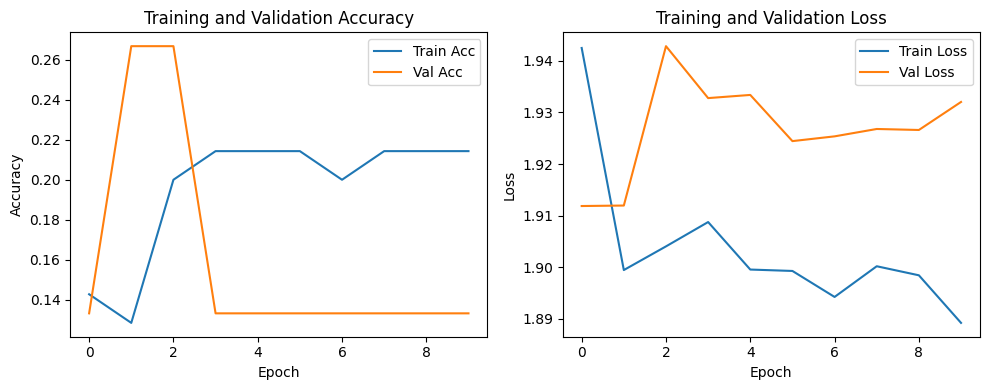

In [36]:
# CNN Classification for Star Spectral Classes

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models

# --- Simulated Data Loading (replace with real data or generation logic) ---
def generate_star_patch():
    x = np.linspace(-3, 3, 64)
    y = np.linspace(-3, 3, 64)
    X, Y = np.meshgrid(x, y)
    patch = np.exp(-(X**2 + Y**2))
    return patch

spectral_classes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Simulate 100 samples
images = []
labels = []
for _ in range(100):
    images.append(generate_star_patch())
    labels.append(np.random.choice(spectral_classes))

# Add synthetic examples if a class is missing
for cls in spectral_classes:
    if cls not in labels:
        for _ in range(10):
            images.append(generate_star_patch())
            labels.append(cls)

# Save to DataFrame and CSV
df = pd.DataFrame({
    'image': images,
    'spectral_class': labels
})
df.to_pickle("catalog.pkl")  # Save numpy arrays properly

# --- Preprocessing ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['spectral_class'])

X = np.stack(df['image'].values)
X = X / X.max()
X = X.reshape(-1, 64, 64, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# --- Model Building ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(spectral_classes), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- Training ---
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val))

# --- Plot Accuracy and Loss ---
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()